(f_rs_mosaic)=

----------------

```{admonition} Learning Objectives
- Create mosaics of more than one multiband image
- Find the intersection of two images
- View the footprint of multiple image tiles

```
```{admonition} Review
* [Opening Remotely Sensed Data](f_rs_io.md)
* [Raster Operations](e_raster_op_intro.md)
```
----------------
<!-- https://www.l3harrisgeospatial.com/docs/MosaicSeamless.html -->
<!-- 
https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/what-is-a-mosaic.htm -->

# Handle Multiple Remotely Sensed Images
Doing analysis over larger areas often requires the use of image mosaics (combining two or more images). Luckily for us geowombat makes this process relatively easy. 

## Union (Mosaic) of Remotely Sensed Image
As an example let's plot the union with `mosaic=True` of two images taken on the same day, for the overlapping portions we will use the mean pixel value by setting `overlap='mean'`, but blue band only. Alternatively we could use one of 'mean', 'min', or 'max'.

Note we rename the band name with `band_names=['blue']`.

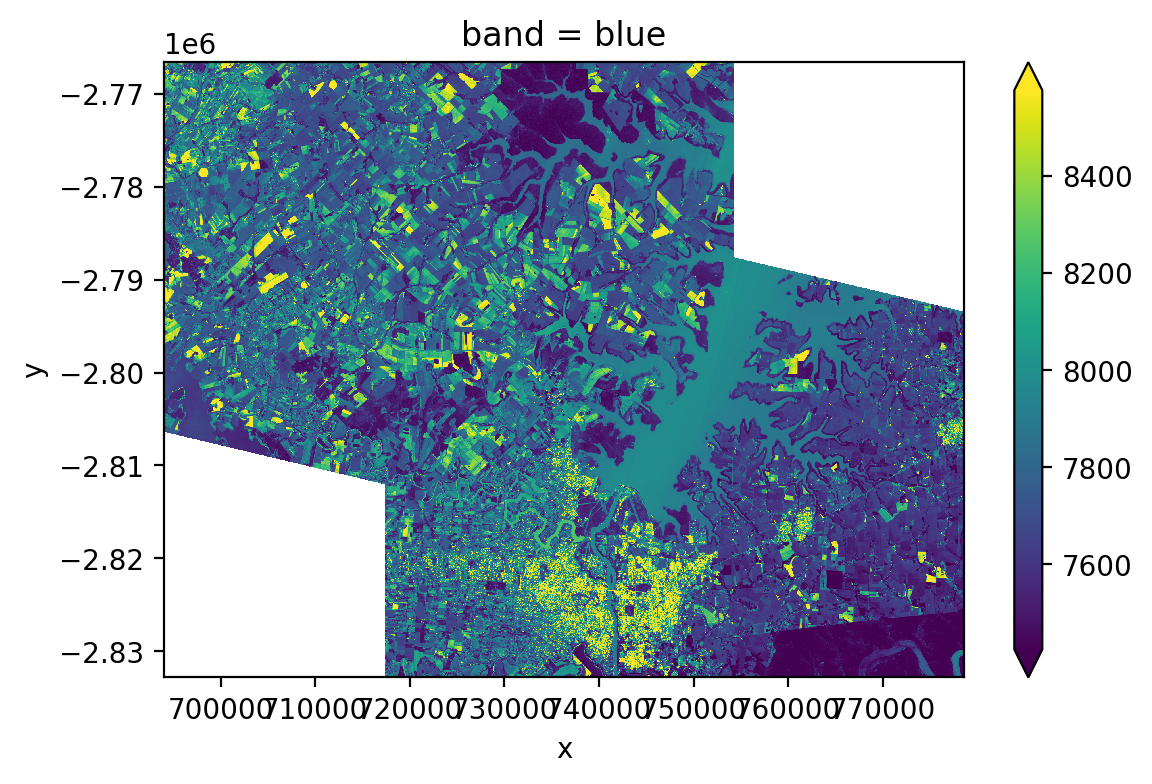

In [1]:
# Import GeoWombat
import geowombat as gw

# import plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# load data
from geowombat.data import l8_224077_20200518_B2, l8_224078_20200518_B2

fig, ax = plt.subplots(dpi=200)
filenames = [l8_224077_20200518_B2, l8_224078_20200518_B2]
with gw.open(filenames,
                band_names=['blue'],
                mosaic=True,
                overlap = 'mean',
                bounds_by='union') as src:
    src.where(src != 0).sel(band='blue').plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## Intersection of Remotely Sensed Image
Same idea with the intersection, using `bounds_by='intersection'`, we still need to mosaic the two images `mosaic=True`.

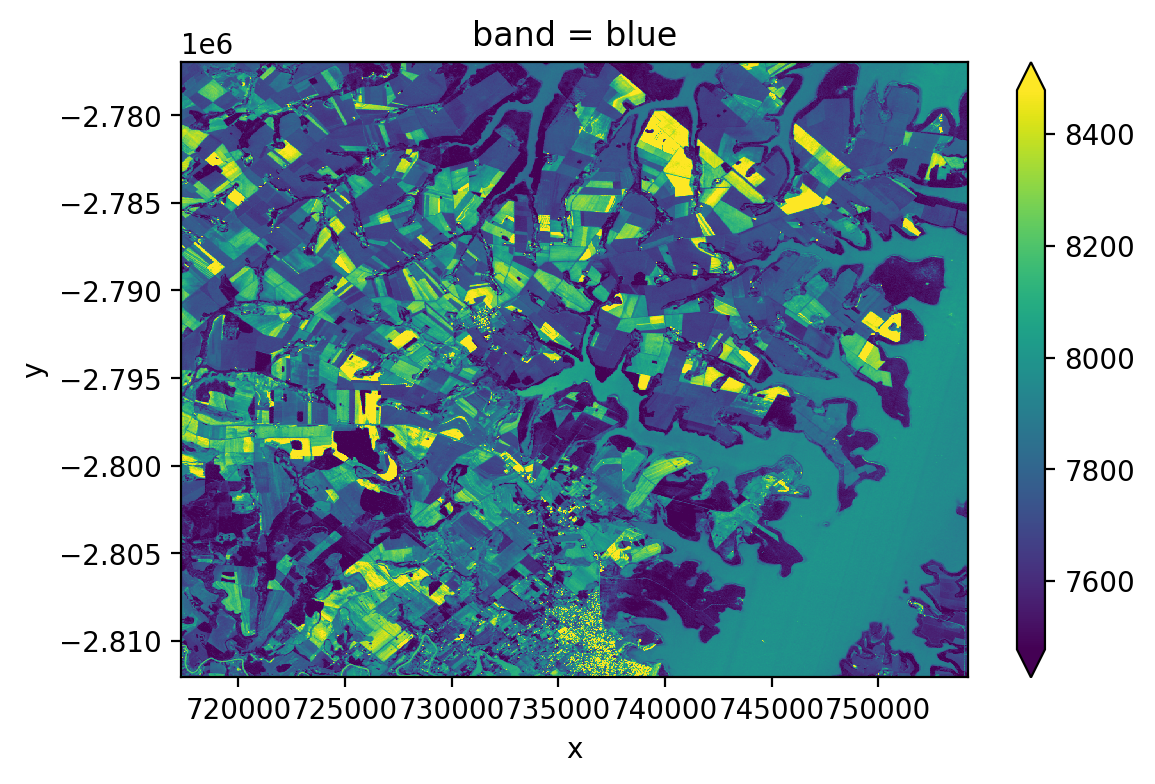

In [2]:
fig, ax = plt.subplots(dpi=200)
filenames = [l8_224077_20200518_B2, l8_224078_20200518_B2]
with gw.open(filenames,
                band_names=['blue'],
                mosaic=True,
                overlap='mean',
                bounds_by='intersection') as src:
    src.where(src != 0).sel(band='blue').plot.imshow(robust=True, ax=ax)
plt.tight_layout(pad=1)

## View Image Tile Footprints
Here we set up a more complicated plotting function for near IR 'nir'.  Note the use of `footprint_grid`.

In [3]:
from geowombat.data import l8_224077_20200518_B4, l8_224078_20200518_B4

def plot(bounds_by, ref_image=None, cmap='viridis'):
    fig, ax = plt.subplots(dpi=200)
    with gw.config.update(ref_image=ref_image):
        with gw.open([l8_224077_20200518_B4, l8_224078_20200518_B4],
                        band_names=['nir'],
                        chunks=256,
                        mosaic=True,
                        bounds_by=bounds_by) as srca:
            # Plot the NIR band
            srca.where(srca != 0).sel(band='nir').plot.imshow(robust=True, cbar_kwargs={'label': 'DN'}, ax=ax)
            # Plot the image chunks
            srca.gw.chunk_grid.plot(color='none', edgecolor='k', ls='-', lw=0.5, ax=ax)
            # Plot the image footprints
            srca.gw.footprint_grid.plot(color='none', edgecolor='orange', lw=2, ax=ax)
            # Label the image footprints
            for row in srca.gw.footprint_grid.itertuples(index=False):
                ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y,
                            s=50, color='red', edgecolor='white', lw=1)
                ax.annotate(row.footprint.replace('.TIF', ''),
                            (row.geometry.centroid.x, row.geometry.centroid.y),
                            color='black',
                            size=8,
                            ha='center',
                            va='center',
                            path_effects=[pe.withStroke(linewidth=1, foreground='white')])
            # Set the display bounds
            ax.set_ylim(srca.gw.footprint_grid.total_bounds[1]-10, srca.gw.footprint_grid.total_bounds[3]+10)
            ax.set_xlim(srca.gw.footprint_grid.total_bounds[0]-10, srca.gw.footprint_grid.total_bounds[2]+10)
    title = f'Image {bounds_by}' if bounds_by else str(Path(ref_image).name.split('.')[0]) + ' as reference'
    size = 12 if bounds_by else 8
    ax.set_title(title, size=size)
    plt.tight_layout(pad=1)

The two plots below illustrate how two images can be mosaicked. The orange grids highlight the image footprints while the black grids illustrate the ``DataArray`` chunks.

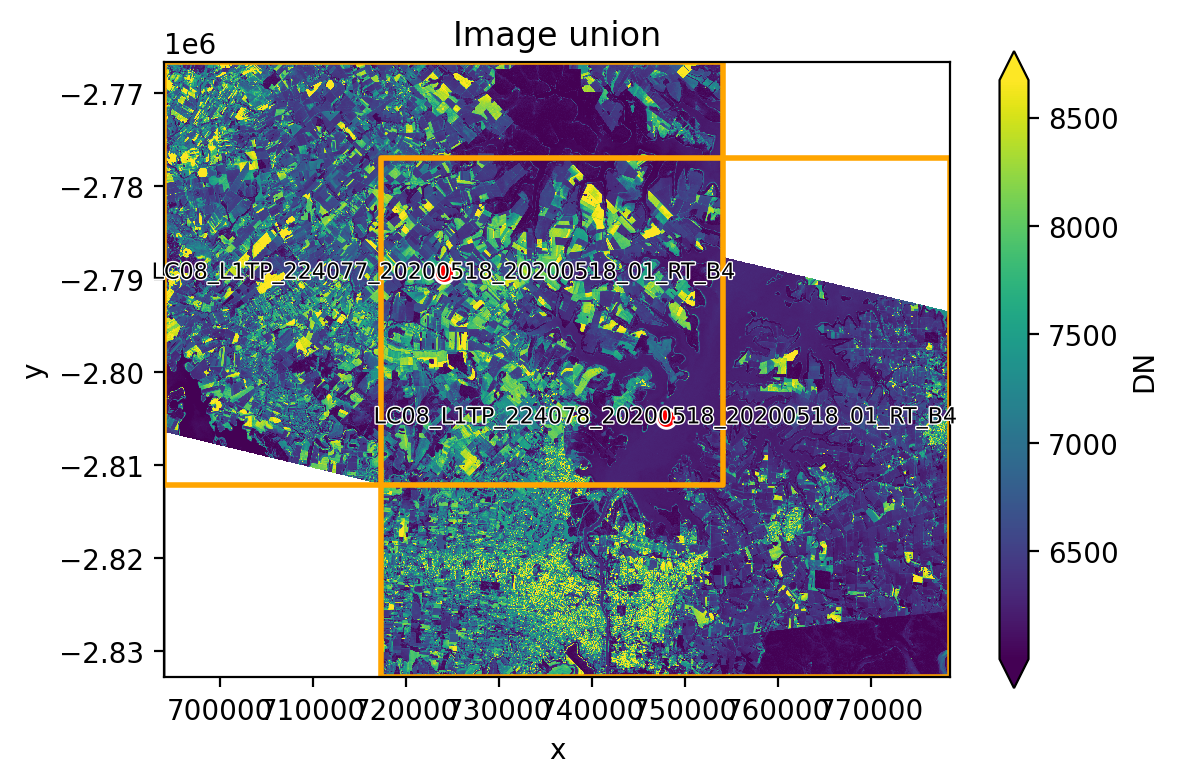

In [4]:
plot('union')